# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM
from matplotlib.colors import LogNorm

Load feature names.

In [2]:
feature_names = []
with open('Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [3]:
X, Y = [], []

with open('Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

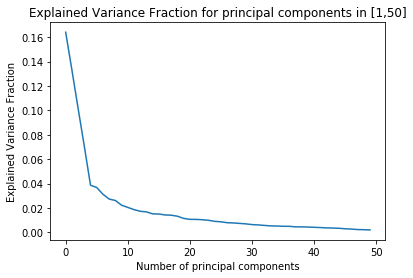

In [4]:
def P1():
### STUDENT START ###
    n_comp = 50
    pca = PCA(n_components=n_comp)
    pca.fit(train_data)
    plt.plot(pca.explained_variance_ratio_)
    plt.xlabel('Number of principal components')
    plt.ylabel('Explained Variance Fraction')
    plt.title("Explained Variance Fraction for principal components in [1,50]")

### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

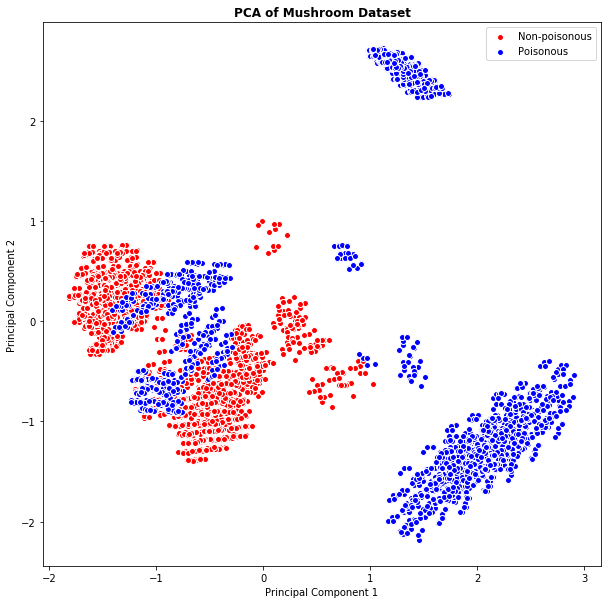

In [5]:
def P2():
### STUDENT START ###
    pca = PCA(n_components=2)
    train_data_r = pca.fit(train_data).transform(train_data)
    
    colors = ['red', 'blue']

    plt.figure(figsize=(10, 10))
    for color, i, target_name in zip(colors, [0, 1], ['Non-poisonous', 'Poisonous']):
        plt.scatter(train_data_r[train_labels == i, 0], train_data_r[train_labels == i, 1], 
                    color=color, lw=1, label=target_name, edgecolors= "white")
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of Mushroom Dataset', weight='bold')
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

In [6]:
import matplotlib.patches as mpatches

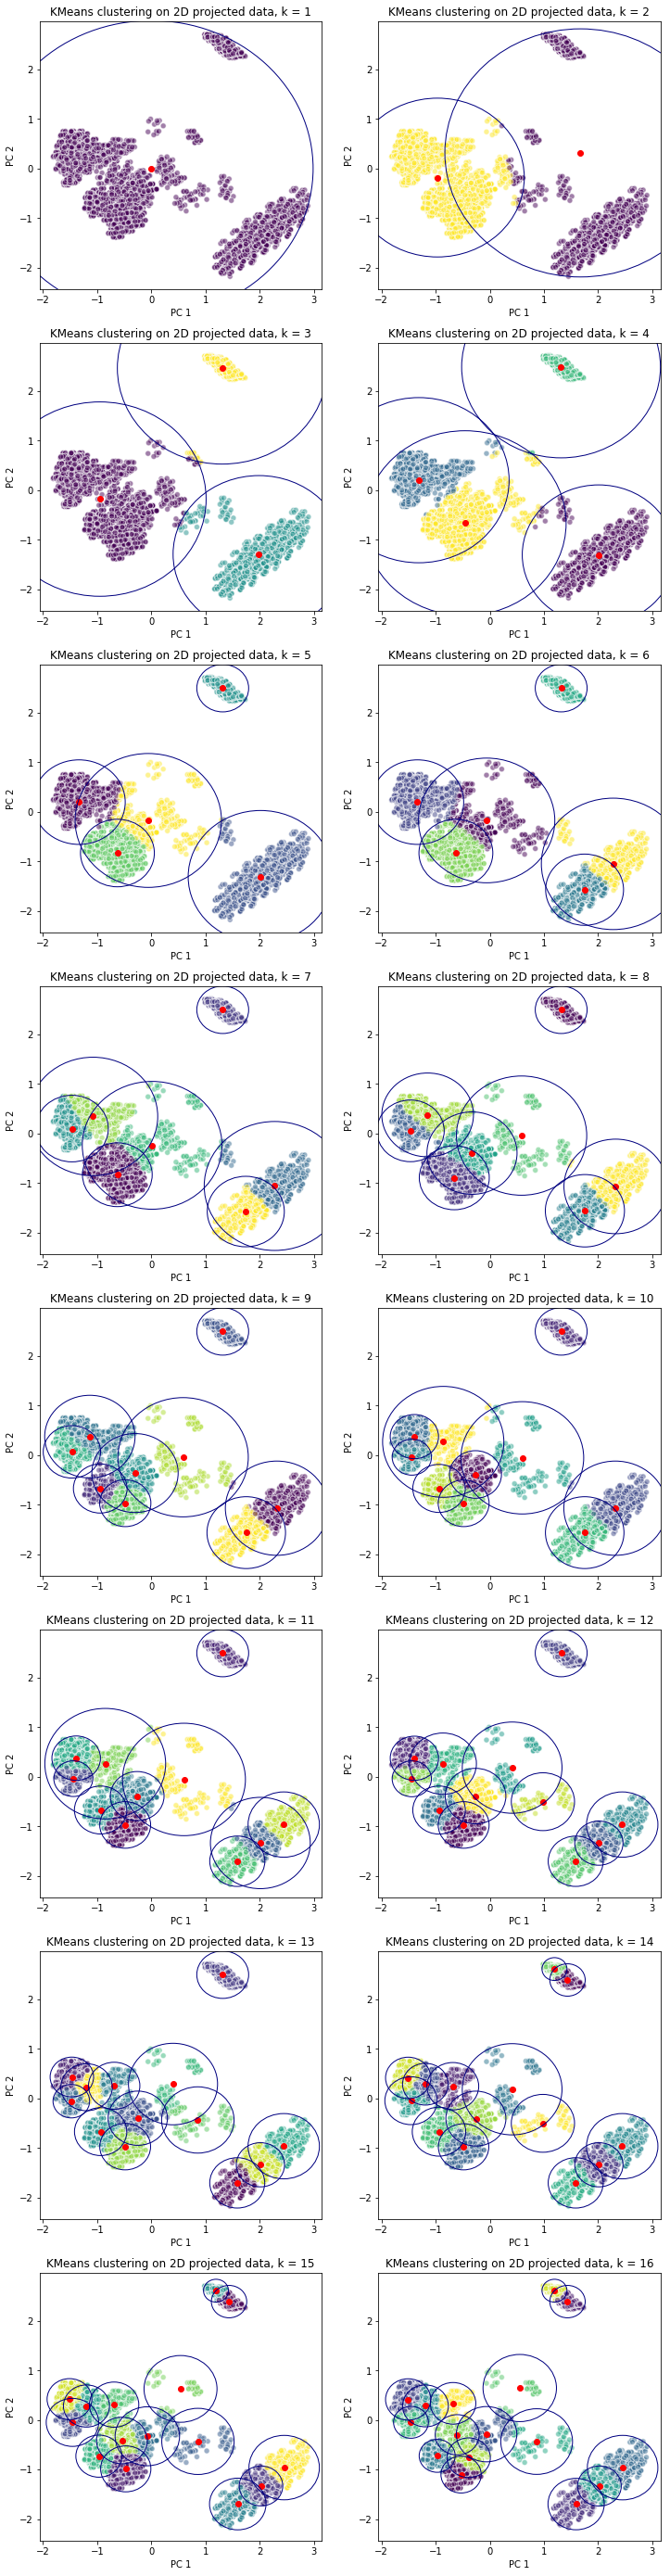

In [7]:
def P3():
### STUDENT START ###
    # Run PCA to reduce train data feature dimensions to 2
    pca = PCA(n_components=2)
    train_data_r = pca.fit(train_data).transform(train_data)
    
    n_clusters = 16
    fig = plt.figure(figsize=(12,50))

    # Run kmeans from 1 to 16, and then draw scatter plot on subplot
    # Mark center of each cluster with red dot
    for k in range(1, n_clusters+1):
        ax = fig.add_subplot(8, 2, k)
        k_means = KMeans(init='k-means++', n_clusters=k, n_init=10).fit(train_data_r)
        centers = np.array(k_means.cluster_centers_)
        # Plot clusters of points based on k_means model
        ax.scatter(train_data_r[:,0], train_data_r[:,1], c=k_means.labels_.astype(float),
                   alpha=.5, edgecolors= "white")
        ax.scatter(centers[:,0], centers[:,1], color='r')
        # Go through each cluster:
        # find the farthest point of each cluster by computing Euclidian distance between each point and center
        # save the radius of each cluster in clusters_radii
        # plot circle for each cluster 
        for cluster in range(centers.shape[0]):
            clusters_radii = max([np.linalg.norm(np.subtract(i, centers[cluster])) 
                                 for i in zip(train_data_r[k_means.labels_ == cluster, 0], 
                                              train_data_r[k_means.labels_ == cluster, 1])])
            art = mpatches.Circle(centers[cluster], clusters_radii, fill=False, edgecolor='navy')
            ax.add_patch(art)
        
        ax.set_title('KMeans clustering on 2D projected data, k = '+ str(k))
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')


### STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

In [8]:
#Ignore Warnings Generated
import warnings
warnings.filterwarnings('ignore')

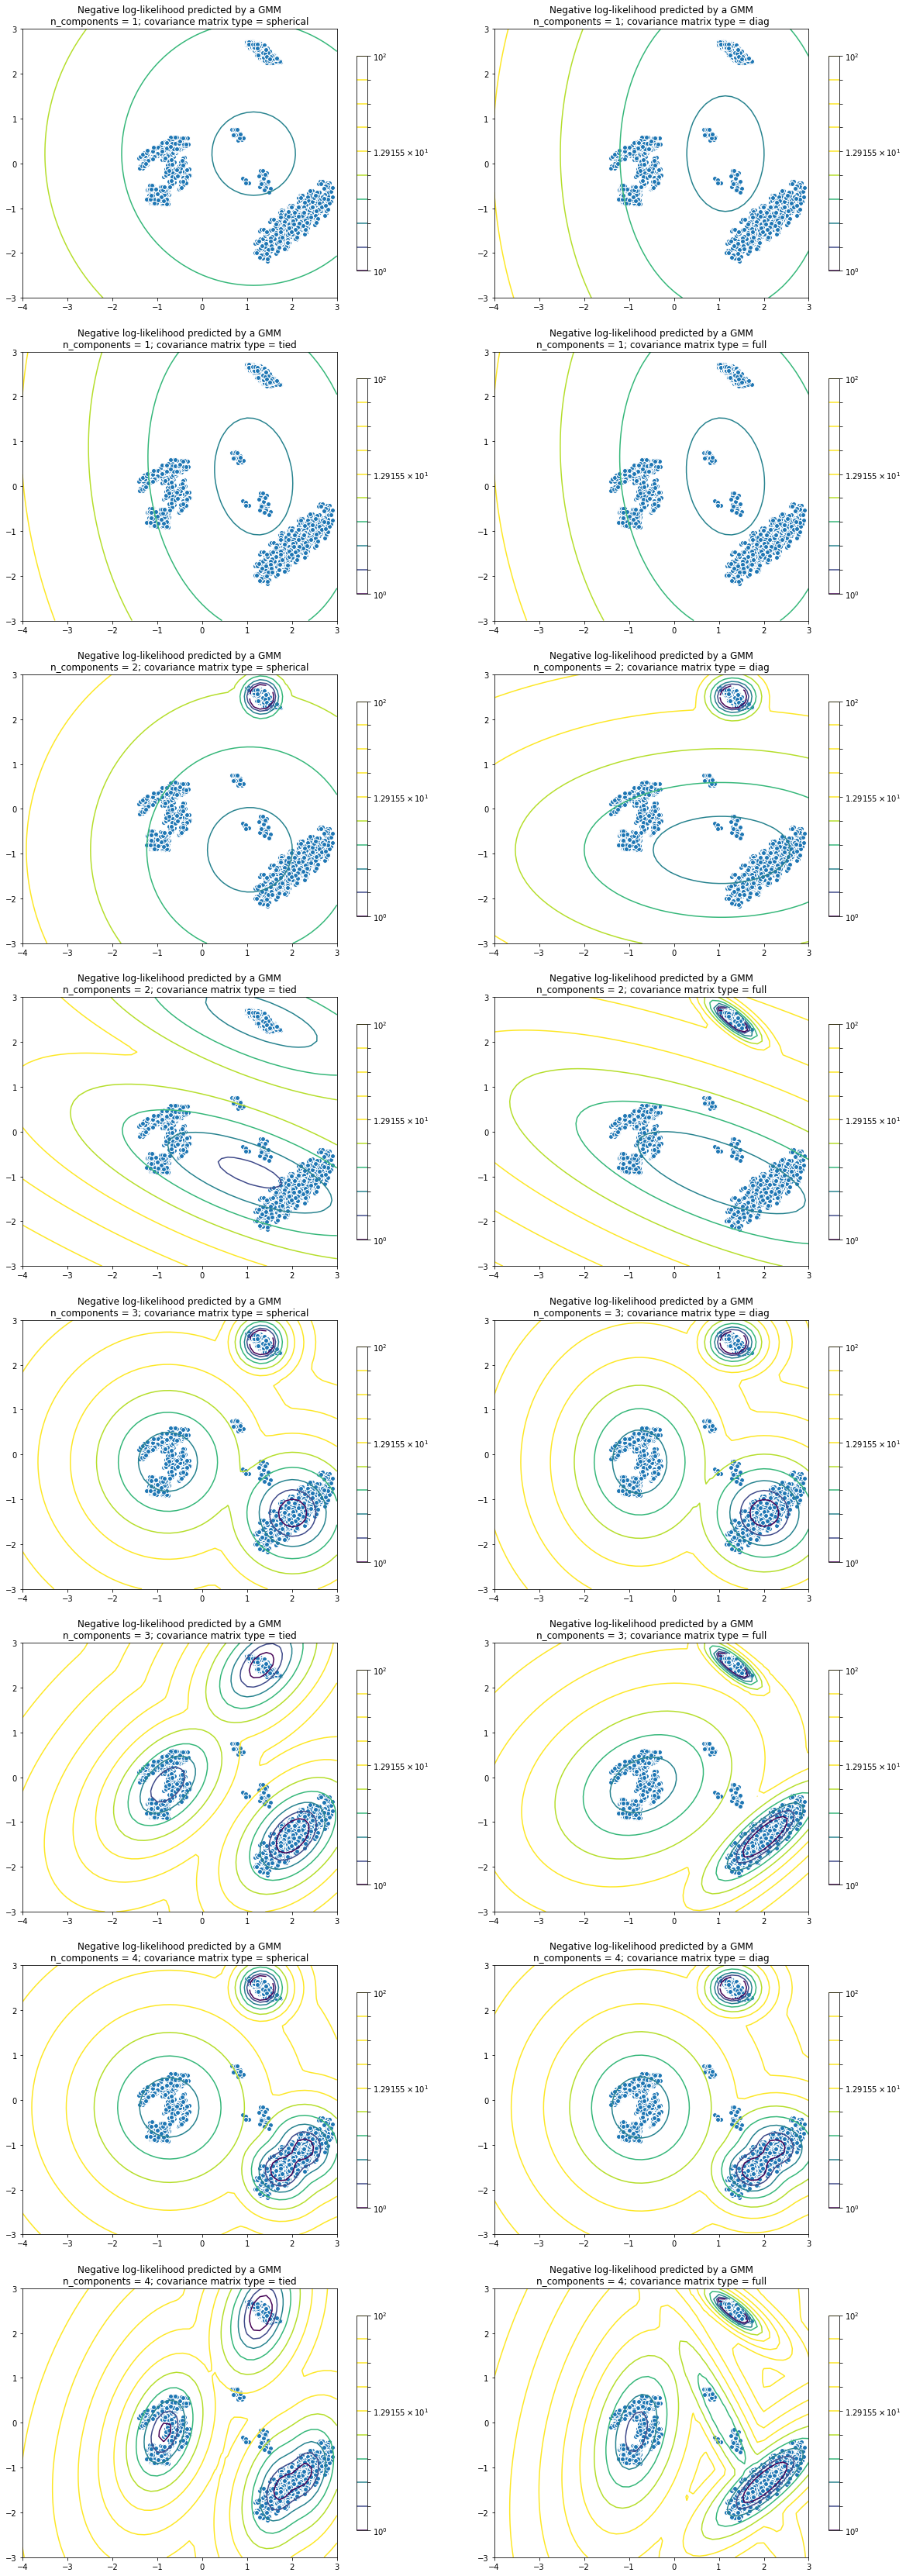

In [10]:
def P4():
### STUDENT START ###
    # Run PCA to reduce train_data to 2D
    pca = PCA(n_components=2)
    train_data_r = pca.fit(train_data).transform(train_data)
    train_data_rp = train_data_r[train_labels==1]
    
    # Set the varying range of hyperparameters
    n_comp_range = [1, 2, 3, 4]
    covar_types = ['spherical', 'diag', 'tied', 'full']
    seed = 0
    
    # Set the overall figure size
    fig = plt.figure(figsize=(20,60))
    # Initiate the counter position of subplot
    i = 1
    
    for n_comp in n_comp_range:
        for covar in covar_types:
            gm_mod = GMM(n_components = n_comp, covariance_type=covar, random_state=seed)
            gm_mod.fit(train_data_rp)
        
            # Plot contour plot for each varying combination of n_comp & covar
            ax = fig.add_subplot(8, 2, i)
            
            # Code copied from scikit-learn: display predicted scores by the model as a contour plot
            x = np.linspace(-4., 3.)
            y = np.linspace(-3., 3.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm_mod.score_samples(XX)
            Z = Z.reshape(X.shape)

            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=10.0),
                             levels=np.logspace(0, 2, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            ax.scatter(train_data_rp[:, 0], train_data_rp[:, 1], edgecolors='white', marker='o')

            ax.set_title('Negative log-likelihood predicted by a GMM\n' + 'n_components = ' + 
                         str(n_comp) + "; covariance matrix type = " + str(covar))
            ax.axis('tight')
            
            i += 1
    

### STUDENT END ###

P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [11]:
def P5():
### STUDENT START ###
    # Run PCA to reduce train_data to 2D
    pca = PCA(n_components=2).fit(train_data)
    train_data_r = pca.transform(train_data)
    train_data_rp = train_data_r[train_labels==1] # positive examples in train data
    train_data_rn = train_data_r[train_labels==0] # negative examples in train data
    
    # Run PCA to reduce test_data to 2D
    test_data_r = pca.transform(test_data)
    
    # Fit two 4-component full covariance GMM models
    # One on positive examples
    # One on negative examples
    n_comp = 4
    covar = 'full'
    seed = 0
    gm_pos = GMM(n_components = n_comp, covariance_type=covar, random_state=seed).fit(train_data_rp)
    gm_neg = GMM(n_components = n_comp, covariance_type=covar, random_state=seed).fit(train_data_rn)
    
    # Calculate the log prob for each sample in test data using these two GMM
    gm_pos_scores = gm_pos.score_samples(test_data_r)
    gm_neg_scores = gm_neg.score_samples(test_data_r)
    
    # Predict the labels by comparing log probs of the two models
    # if log_prob(pos GMM) > log_prob(neg GMM) --> predicted as "positive" = 1
    # otherwise, predicted as "negative" = 0
    preds = (gm_pos_scores > gm_neg_scores) + 0

    # Calculate the accuracy
    accuracy = np.mean(preds == test_labels)
    print("Total predictions on test data:", test_labels.shape[0])
    print("The 4-component full covariance GMM prediction accuracy on test data:", accuracy)
    

### STUDENT END ###

P5()

Total predictions on test data: 1124
The 4-component full covariance GMM prediction accuracy on test data: 0.9501779359430605


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [13]:
def P6():
### STUDENT START ###
    def ExperimentModel(train_data=train_data, test_data=test_data, pca_comp_range=None, 
                        gmm_comp_range=None, gmm_covar_types=None, random_state=0):
        '''
        A function to loop through all parameters of PCA and GMM models, to print out:
        - Parameter combination of each loop
        - Accuracy of each loop
        - Best parameters with the highest accuracy
        '''
        # Initiate list and dict to store accuracies and best parameter
        accuracies = []
        best_param = {'PCA_component': None, 'GMM_component': None, 'GMM_covariance_type': None}
        
        ## Experiment with PCA components
        for pca_comp in pca_comp_range:
            # Run PCA to reduce train_data
            pca = PCA(n_components=pca_comp).fit(train_data)
            train_data_r = pca.transform(train_data)
            train_data_rp = train_data_r[train_labels==1] # positive examples in train data
            train_data_rn = train_data_r[train_labels==0] # negative examples in train data

            # Run PCA to reduce test_data
            test_data_r = pca.transform(test_data)

            ## Experiment with different parameters of GMM models
            # One GMM model trained on positive examples
            # One GMM model trained on negative examples
            for n_comp in gmm_comp_range:
                for covar in gmm_covar_types:
                    gm_pos = GMM(n_components=n_comp, covariance_type=covar, 
                                 random_state=random_state).fit(train_data_rp)
                    gm_neg = GMM(n_components=n_comp, covariance_type=covar, 
                                 random_state=random_state).fit(train_data_rn)

                    # Calculate the log prob for each sample in test data using these two GMM
                    gm_pos_scores = gm_pos.score_samples(test_data_r)
                    gm_neg_scores = gm_neg.score_samples(test_data_r)

                    # Predict the labels by comparing log probs of the two models
                    # if log_prob(pos GMM) > log_prob(neg GMM) --> predicted as "positive" = 1
                    # otherwise, predicted as "negative" = 0
                    preds = (gm_pos_scores > gm_neg_scores) + 0

                    # Calculate the accuracy & update best parameter dict
                    accuracy = np.mean(preds == test_labels)
                    if len(accuracies) != 0:
                        if accuracy > max(accuracies):
                            best_param['PCA_component'] = pca_comp
                            best_param['GMM_component'] = n_comp
                            best_param['GMM_covariance_type'] = covar
                    accuracies.append(accuracy)
                    print("Experiment Parameters:")
                    print("PCA component:", pca_comp, " GMM component:", n_comp, 
                          " GMM covariance type:", covar)
                    print("Prediction accuracy on test data:", accuracy)
                    print("="*70 + "\n")
        
        print("*"*70)
        print("Best parameters with highest accuracy:")
        for key, value in best_param.items():
            print(str(key) + ":", value)
        print("Highest accuracy:", max(accuracies))
        print("*"*70)

    ### Run experiment Batch 1
    pca_comp_range1 = range(2, 13)
    gmm_comp_range1 = range(1, 5)
    gmm_covar_types1 = ['tied']
    ExperimentModel(train_data=train_data, test_data=test_data, pca_comp_range=pca_comp_range1, 
                    gmm_comp_range=gmm_comp_range1, gmm_covar_types=gmm_covar_types1, random_state=0)

    print("\n")
    
    ### Run experiment Batch 2
    pca_comp_range2 = range(2, 5)
    gmm_comp_range2 = range(1, 5)
    gmm_covar_types2 = ['spherical', 'diag', 'full']
    ExperimentModel(train_data=train_data, test_data=test_data, pca_comp_range=pca_comp_range2, 
                    gmm_comp_range=gmm_comp_range2, gmm_covar_types=gmm_covar_types2, random_state=0)
    
### STUDENT END ###

P6()

Experiment Parameters:
PCA component: 2  GMM component: 1  GMM covariance type: tied
Prediction accuracy on test data: 0.8620996441281139

Experiment Parameters:
PCA component: 2  GMM component: 2  GMM covariance type: tied
Prediction accuracy on test data: 0.8896797153024911

Experiment Parameters:
PCA component: 2  GMM component: 3  GMM covariance type: tied
Prediction accuracy on test data: 0.9448398576512456

Experiment Parameters:
PCA component: 2  GMM component: 4  GMM covariance type: tied
Prediction accuracy on test data: 0.9457295373665481

Experiment Parameters:
PCA component: 3  GMM component: 1  GMM covariance type: tied
Prediction accuracy on test data: 0.8656583629893239

Experiment Parameters:
PCA component: 3  GMM component: 2  GMM covariance type: tied
Prediction accuracy on test data: 0.854982206405694

Experiment Parameters:
PCA component: 3  GMM component: 3  GMM covariance type: tied
Prediction accuracy on test data: 0.9234875444839857

Experiment Parameters:
PCA c

Experiment Parameters:
PCA component: 12  GMM component: 1  GMM covariance type: tied
Prediction accuracy on test data: 0.9626334519572953

Experiment Parameters:
PCA component: 12  GMM component: 2  GMM covariance type: tied
Prediction accuracy on test data: 0.9768683274021353

Experiment Parameters:
PCA component: 12  GMM component: 3  GMM covariance type: tied
Prediction accuracy on test data: 0.9919928825622776

Experiment Parameters:
PCA component: 12  GMM component: 4  GMM covariance type: tied
Prediction accuracy on test data: 0.9928825622775801

**********************************************************************
Best parameters with highest accuracy:
PCA_component: 12
GMM_component: 4
GMM_covariance_type: tied
Highest accuracy: 0.9928825622775801
**********************************************************************


Experiment Parameters:
PCA component: 2  GMM component: 1  GMM covariance type: spherical
Prediction accuracy on test data: 0.8603202846975089

Experiment Para

> From the above two batches of experiments, we found that:
- Batch 1: Best parameters with highest accuracy:
    - PCA_component: 12
    - GMM_component: 4
    - GMM_covariance_type: tied
    - Highest accuracy: 0.9928825622775801
    - Number of parameters =  (12 mean vector + 12 covariance matrix) x 2 classes = 48 parameters.
- Batch 2: Best parameters with highest accuracy:
    - PCA_component: 3
    - GMM_component: 4
    - GMM_covariance_type: spherical
    - Highest accuracy: 0.9599644128113879
    - Number of parameters = ( (3 mean vector + 3 covariance matrix) x 4 components ) x 2 classes = 48 parameters.